In [1]:
import sys
import os
import subprocess

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from functools import reduce

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.ticker as ticker

current_dir = os.getcwd()
module_path = os.path.abspath(os.path.join(current_dir, '..', 'libs'))
if module_path not in sys.path:
    sys.path.append(module_path)
from SCOU_NC_LoQ_NUTS import *

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def visualize_and_export(input_file, obs, lod, loq, molecule):

    output_file = input_file.copy()
    
    # preprocessing in log10 scale:
    for column in ['muX', 'ICL', 'ICU', obs, lod, loq]:
        output_file[column] = np.log10(np.exp(output_file[column]))

    
    output_file = output_file.rename(columns={obs:'obs',
                                            lod:'lod',
                                            loq:'loq'})

    # visualization:
    with plt.style.context(['science', 'notebook', 'grid']):
    
        LABEL_SIZE = 30
        TICK_SIZE = 30
        TITLE_SIZE = 38
        LEGEND_SIZE = 30
        DATES_SIZE = 18
        figsize = (28, 10) #figsize = (32, 10)
        
        plt.rc('axes', labelsize=LABEL_SIZE)
        plt.rc('xtick', labelsize=TICK_SIZE)   
        plt.rc('ytick', labelsize=TICK_SIZE)
        plt.rc('figure', titlesize=TITLE_SIZE)
        plt.rc('legend', fontsize=LEGEND_SIZE)
        plt.rcParams['text.usetex'] = True
        
        fig = plt.figure(figsize=figsize, layout="constrained")
        
        ax_dict = fig.subplot_mosaic(
            """
            A
            """
        )
        
        ### A
        ax_dict['A'].plot(output_file.dateStart.values, output_file.muX.values, label='Smoothed signal', color='green', linewidth=8, zorder=3)
        
        ax_dict['A'].plot(output_file.dateStart.values, output_file.ICL.values, label='95% CI', linestyle='--', color='green', linewidth=5, zorder=1)
        ax_dict['A'].plot(output_file.dateStart.values, output_file.ICU.values, linestyle='--', color='green', linewidth=5, zorder=1)
        
        ax_dict['A'].fill_between(output_file.dateStart.values, output_file.ICL.values, output_file.ICU.values, alpha=.3, color='green')
    
        
        scatter_points = ax_dict['A'].scatter(output_file.dateStart.values, output_file.obs.values, label='Measurements', 
                             c=output_file.pout.values,
                             cmap='bwr', edgecolor='black', s=360, zorder=3,
                             linewidths=1.5, alpha=0.9, vmin=0, vmax=1)
    
        lod_points = ax_dict['A'].scatter(output_file.loc[output_file.obs<=output_file.lod].dateStart.values,
                                          output_file.loc[output_file.obs<=output_file.lod].obs.values,
                             color='none', edgecolor='red', s=520, zorder=2, linewidth=5, label="LoD")
    
        loq_points = ax_dict['A'].scatter(output_file.loc[(output_file.obs<=output_file.loq)&(output_file.obs>output_file.lod)].dateStart.values,
                                          output_file.loc[(output_file.obs<=output_file.loq)&(output_file.obs>output_file.lod)].obs.values,
                             color='none', edgecolor='orange', s=520, zorder=2, linewidth=5, label="LoQ")
    
        ax_dict['A'].set_ylabel("Flux (GU) - $\log_{10}$ scale")
        ax_dict['A'].set_xlabel("Sampling date")
        ax_dict['A'].tick_params(axis='x', labelsize=TICK_SIZE)
        ax_dict['A'].tick_params(axis='y', labelsize=TICK_SIZE)
        ax_dict['A'].grid(linewidth=1, color='black', alpha=0.8)
        ax_dict['A'].set_title('HPV_HF', size=TITLE_SIZE)
    
        ### Outlier probability legend:
        cmin, cmax = 0.0, 1.0 
        axins1 = inset_axes(ax_dict['A'], width='50%', height='100%', 
                            bbox_to_anchor=(1.075-0.035, 0, 0.02, 1), 
                            bbox_transform=ax_dict['A'].transAxes, 
                            borderpad=0)
        axins1.grid(False)
        cbar = fig.colorbar(scatter_points, cax=axins1, orientation='vertical')
        
        custom_ticks = [0.0, 1.0]
        cbar.set_ticks(custom_ticks)
    
        ref_label = ax_dict['A'].get_yticklabels()[0] 
        font_props = ref_label.get_fontproperties()
        decimal_places = 1
        cbar.ax.set_yticklabels([f"{val:.{decimal_places}f}" for val in custom_ticks], fontsize=TICK_SIZE, fontproperties=font_props)                            
        cbar.ax.set_ylabel('Outlier probabilities', size=TICK_SIZE, labelpad=-30)
    
        axins1 = inset_axes(ax_dict['A'], width='50%', height='100%', 
                            bbox_to_anchor=(1.062-0.035, 0, 0.02, 1), 
                            bbox_transform=ax_dict['A'].transAxes, 
                            borderpad=0)
        axins1.grid(False)
    
        # Main legend
        plt.rcParams['text.usetex'] = False
        h1, l1 = ax_dict['A'].get_legend_handles_labels()
        fig.legend(h1, l1, loc='upper center', bbox_to_anchor=(0.5, 0), fancybox=True, shadow=True, ncol=5)
        
        plt.show()
    
    # export:
    output_file.to_csv('../outputs/files/3010/' + molecule + '.csv', sep=';', index=False)

In [3]:
def notify_mac(title, message):
    script = f'display notification "{message}" with title "{title}"'
    subprocess.run(['osascript', '-e', script])

In [4]:
filepath = '../data/HPV 66 et 6.xlsx'
data_HPV_HF = pd.read_excel(filepath, sheet_name='HPV 66')

# selecting only relevant variables:
data_HPV_HF = data_HPV_HF.iloc[:, [1, 9]]
data_HPV_HF = data_HPV_HF.loc[1:]
data_HPV_HF.columns = ['dateStart', 'obs_HPV']

# Manual inputs for dateStart
data_HPV_HF.dateStart = data_HPV_HF.dateStart.replace('03/07/2024', '2024-07-03')
data_HPV_HF.dateStart = data_HPV_HF.dateStart.replace('01/09/2024', '2024-09-01')
data_HPV_HF.dateStart = data_HPV_HF.dateStart.replace('04/09/2024', '2024-09-04')
data_HPV_HF.dateStart = data_HPV_HF.dateStart.replace('10/08/2024', '2024-08-10')
data_HPV_HF.dateStart = data_HPV_HF.dateStart.replace('14/08/2024', '2024-08-14')
data_HPV_HF.dateStart = data_HPV_HF.dateStart.replace('25/08/2024', '2024-08-25')
data_HPV_HF.dateStart = data_HPV_HF.dateStart.replace('03/11/2024', '2024-11-03')
data_HPV_HF.dateStart = data_HPV_HF.dateStart.replace('06/11/2024', '2024-11-06')
data_HPV_HF.dateStart = data_HPV_HF.dateStart.replace('10/11/2024', '2024-11-10')
data_HPV_HF.dateStart = data_HPV_HF.dateStart.replace('01/12/2024', '2024-12-01')
data_HPV_HF.dateStart = data_HPV_HF.dateStart.replace('04/12/2024', '2024-12-04')
data_HPV_HF.dateStart = data_HPV_HF.dateStart.replace('08/12/2024', '2024-12-08')
data_HPV_HF.dateStart = data_HPV_HF.dateStart.replace('05/01/2025', '2025-01-05')

data_HPV_HF.dateStart = pd.to_datetime(data_HPV_HF.dateStart)#, format='DD/MM/YYYY')

data_HPV_HF.obs_HPV = pd.to_numeric(data_HPV_HF.obs_HPV)
data_HPV_HF.sort_values(by='dateStart', inplace=True)
data_HPV_HF.head()

,dateStart,obs_HPV
1,2024-01-24,110.118936
2,2024-01-28,1350.439436
3,2024-01-31,1014.056575
4,2024-02-04,57.800676
5,2024-02-18,708.836426


In [5]:
filepath = '../data/Données HPV V2.xlsx'

data_phages = pd.read_excel(filepath, sheet_name='Hautes fréquences')
data_phages = data_phages.iloc[:, [1, -3, -6, -8]]
data_phages = data_phages.loc[1:]
data_phages.columns = ['dateStart', 'obs_HPV', 'obs_mtDNA', 'obs_crAssphages']

# Manual inputs for dateStart
data_phages.dateStart = data_phages.dateStart.replace('03/07/2024', '2024-07-03')
data_phages.dateStart = data_phages.dateStart.replace('01/09/2024', '2024-09-01')
data_phages.dateStart = data_phages.dateStart.replace('04/09/2024', '2024-09-04')
data_phages.dateStart = data_phages.dateStart.replace('10/08/2024', '2024-08-10')
data_phages.dateStart = data_phages.dateStart.replace('14/08/2024', '2024-08-14')
data_phages.dateStart = data_phages.dateStart.replace('25/08/2024', '2024-08-25')
data_phages.dateStart = data_phages.dateStart.replace('03/11/2024', '2024-11-03')
data_phages.dateStart = data_phages.dateStart.replace('06/11/2024', '2024-11-06')
data_phages.dateStart = data_phages.dateStart.replace('10/11/2024', '2024-11-10')
data_phages.dateStart = data_phages.dateStart.replace('01/12/2024', '2024-12-01')
data_phages.dateStart = data_phages.dateStart.replace('04/12/2024', '2024-12-04')
data_phages.dateStart = data_phages.dateStart.replace('08/12/2024', '2024-12-08')
data_phages.dateStart = data_phages.dateStart.replace('05/01/2025', '2025-01-05')

# dateStart conversion to datetime:
data_phages.dateStart = pd.to_datetime(data_phages.dateStart)#, format='DD/MM/YYYY')

# converting observations to numeric values
for column in ['obs_HPV', 'obs_mtDNA', 'obs_crAssphages']:
    data_phages[column] = pd.to_numeric(data_phages[column])

data_phages.obs_HPV = pd.to_numeric(data_phages.obs_HPV)
data_phages.obs_crAssphages = pd.to_numeric(data_phages.obs_crAssphages)
data_phages.sort_values(by='dateStart', inplace=True)
data_phages.drop_duplicates(subset='dateStart', inplace=True)
data_phages.head()

,dateStart,obs_HPV,obs_mtDNA,obs_crAssphages
1,2024-01-24,18613.855375,5.759871e+05,2.663931e+07
2,2024-01-28,32242.166419,1.411130e+06,5.253436e+07
3,2024-01-31,33190.381878,4.780456e+05,3.806105e+07
4,2024-02-04,64956.400453,5.166544e+04,2.717509e+07
5,2024-02-07,51089.113535,5.791051e+04,2.478178e+07


In [6]:
# double checking the absence of duplicates
data_phages.dateStart.value_counts().values.max()

1

In [7]:
data_HPV_HF.shape

(79, 2)

In [8]:
# completing the timeseries with nans when value is <= LoD 
# because we do observe the signal even though it is not detected

In [9]:
timesteps_whole = data_phages.dateStart.tolist()
missing_timestep = np.setxor1d(timesteps_whole, data_HPV_HF.dateStart.tolist())
missing_timestep.shape

(21,)

In [10]:
starting_index = 100
for j in range(missing_timestep.shape[0]):
    new_entry = [missing_timestep[j], np.nan]
    data_HPV_HF.loc[starting_index+j] = new_entry

In [11]:
# working as intended
data_HPV_HF.sort_values(by='dateStart', inplace=True)

In [12]:
data_HPV_HF['lod_HPV'] = 24
data_HPV_HF['loq_HPV'] = 500

In [13]:
# now completing nans with lod value:
data_HPV_HF.loc[data_HPV_HF.obs_HPV.isna(), 'obs_HPV'] = data_HPV_HF.loc[data_HPV_HF.obs_HPV.isna(), 'lod_HPV']

In [14]:
# we now need to merge both dataframes:
data_phages.set_index('dateStart', inplace=True)
data_HPV_HF.set_index('dateStart', inplace=True)
data_HPV_HF = data_HPV_HF.join(data_phages.loc[::,['obs_crAssphages', 'obs_mtDNA']])

In [15]:
data_HPV_HF.reset_index(inplace=True)
data_HPV_HF.dateStart.value_counts().head()

dateStart
2024-01-24    1
2024-09-25    1
2024-10-30    1
2024-10-27    1
2024-10-23    1
Name: count, dtype: int64

In [16]:
data_HPV_HF.drop_duplicates(subset='dateStart', inplace=True) # just in case

In [17]:
# we now need to take volumes into account

In [18]:
data_HPV_HF.set_index('dateStart', inplace=True)

In [19]:
mapping_dict = {'janvier': '01', 'février': '02', 'mars': '03', 'avril': '04', 'mai': '05',
                              'juin':'06', 'juillet':'07', 'août':'08', 'septembre':'09', 'octobre':'10', 
                              'novembre':'11', 'décembre':'12'}

In [20]:
# getting volumes; first batch from first file:
volumes_clichy = pd.read_excel("../data/Débit sur Clichy 2021 - 2024.xlsx", sheet_name="Données")
volumes_clichy = volumes_clichy.loc[1:]
volumes_clichy.columns = ['dateStart', 'plantVolume']

# there is an inconsistent formatting on Clichy's file, we need to take care of that problem:
volumes_clichy_first_part = volumes_clichy.loc[:1095].copy()
volumes_clichy_second_part = volumes_clichy.loc[1096:].copy()
volumes_clichy_first_part.dateStart = pd.to_datetime(volumes_clichy_first_part.dateStart)

volumes_clichy_second_part['dateStart'] = volumes_clichy_second_part['dateStart'].apply(
    lambda x: reduce(lambda s, kv: s.replace(*kv), mapping_dict.items(), str(x)))

volumes_clichy_second_part.dateStart = volumes_clichy_second_part.dateStart.apply(lambda x: x[:-2] + '2024')
volumes_clichy_second_part.dateStart = volumes_clichy_second_part.dateStart.apply(lambda x: x.split(' ')[1:])
volumes_clichy_second_part.dateStart.apply(lambda x: x.reverse())
volumes_clichy_second_part.dateStart = volumes_clichy_second_part.dateStart.apply(lambda x: '-'.join(x))
volumes_clichy_second_part.dateStart = pd.to_datetime(volumes_clichy_second_part.dateStart)

volumes_clichy.dateStart = volumes_clichy_first_part.dateStart.tolist() + volumes_clichy_second_part.dateStart.tolist()
volumes_clichy.plantVolume = pd.to_numeric(volumes_clichy.plantVolume)
volumes_clichy.set_index('dateStart', inplace=True)

data_HPV_HF = data_HPV_HF.join(volumes_clichy['plantVolume'])
data_HPV_HF.head()

,obs_HPV,lod_HPV,loq_HPV,obs_crAssphages,obs_mtDNA,plantVolume
dateStart,,,,,,
2024-01-24,110.118936,24,500,2.663931e+07,5.759871e+05,680420.0
2024-01-28,1350.439436,24,500,5.253436e+07,1.411130e+06,546090.0
2024-01-31,1014.056575,24,500,3.806105e+07,4.780456e+05,641610.0
2024-02-04,57.800676,24,500,2.717509e+07,5.166544e+04,553110.0
2024-02-07,24,24,500,2.478178e+07,5.791051e+04,693170.0


In [21]:
# getting volumes; second batch from second file:
remaining_volumes = pd.read_excel(filepath, sheet_name='Données débits manquants')
remaining_volumes = remaining_volumes.iloc[:, [0, 2]]
remaining_volumes = remaining_volumes.loc[3:]
remaining_volumes.columns = ['dateStart', 'plantVolume']
remaining_volumes.loc[3, 'dateStart'] = 'lundi 1 décembre 2024'

remaining_volumes.dateStart = remaining_volumes.dateStart.apply(lambda x: str(x).replace('décembre', '12').replace('janvier', '01').replace('février', '02').split(' ')[1:])
remaining_volumes.dateStart.apply(lambda x: x.reverse())
remaining_volumes.dateStart = remaining_volumes.dateStart.apply(lambda x: '-'.join(x))
remaining_volumes.dateStart = pd.to_datetime(remaining_volumes.dateStart)
remaining_volumes.set_index('dateStart', inplace=True)


data_HPV_HF['plantVolume'] = data_HPV_HF['plantVolume'].combine_first(remaining_volumes['plantVolume'])
data_HPV_HF.reset_index(inplace=True)
data_HPV_HF.plantVolume = 1000 * data_HPV_HF.plantVolume
data_HPV_HF.head()

,dateStart,obs_HPV,lod_HPV,loq_HPV,obs_crAssphages,obs_mtDNA,plantVolume
0,2024-01-24,110.118936,24,500,2.663931e+07,5.759871e+05,680420000.0
1,2024-01-28,1350.439436,24,500,5.253436e+07,1.411130e+06,546090000.0
2,2024-01-31,1014.056575,24,500,3.806105e+07,4.780456e+05,641610000.0
3,2024-02-04,57.800676,24,500,2.717509e+07,5.166544e+04,553110000.0
4,2024-02-07,24,24,500,2.478178e+07,5.791051e+04,693170000.0


In [22]:
# normalizing HPV obs with both proxies to take into account inhibition and extraction efficiency:
data_HPV_HF['obs_HPV_mtDNA'] = data_HPV_HF['obs_HPV'].div(data_HPV_HF['obs_mtDNA'])
data_HPV_HF['lod_HPV_mtDNA'] = data_HPV_HF['lod_HPV'].div(data_HPV_HF['obs_mtDNA'])
data_HPV_HF['loq_HPV_mtDNA'] = data_HPV_HF['loq_HPV'].div(data_HPV_HF['obs_mtDNA'])

data_HPV_HF['obs_HPV_crAssphages'] = data_HPV_HF['obs_HPV'].div(data_HPV_HF['obs_crAssphages'])
data_HPV_HF['lod_HPV_crAssphages'] = data_HPV_HF['lod_HPV'].div(data_HPV_HF['obs_crAssphages'])
data_HPV_HF['loq_HPV_crAssphages'] = data_HPV_HF['loq_HPV'].div(data_HPV_HF['obs_crAssphages'])

# getting flow normalized obs by multiplying obs with plantVolume:
data_HPV_HF['obs_flux'] = data_HPV_HF['obs_HPV'] * data_HPV_HF['plantVolume']
data_HPV_HF['lod_flux'] = data_HPV_HF['lod_HPV'] * data_HPV_HF['plantVolume']
data_HPV_HF['loq_flux'] = data_HPV_HF['loq_HPV'] * data_HPV_HF['plantVolume']


In [23]:
data_HPV_HF.head()

,dateStart,obs_HPV,lod_HPV,loq_HPV,obs_crAssphages,obs_mtDNA,plantVolume,obs_HPV_mtDNA,lod_HPV_mtDNA,loq_HPV_mtDNA,obs_HPV_crAssphages,lod_HPV_crAssphages,loq_HPV_crAssphages,obs_flux,lod_flux,loq_flux
0,2024-01-24,110.118936,24,500,2.663931e+07,5.759871e+05,680420000.0,0.000191,0.000042,0.000868,0.000004,9.009242e-07,0.000019,74927126169.021988,1.633008e+10,3.402100e+11
1,2024-01-28,1350.439436,24,500,5.253436e+07,1.411130e+06,546090000.0,0.000957,0.000017,0.000354,0.000026,4.568438e-07,0.000010,737461471525.583496,1.310616e+10,2.730450e+11
2,2024-01-31,1014.056575,24,500,3.806105e+07,4.780456e+05,641610000.0,0.002121,0.000050,0.001046,0.000027,6.305659e-07,0.000013,650628839140.596924,1.539864e+10,3.208050e+11
3,2024-02-04,57.800676,24,500,2.717509e+07,5.166544e+04,553110000.0,0.001119,0.000465,0.009678,0.000002,8.831617e-07,0.000018,31970132095.323891,1.327464e+10,2.765550e+11
4,2024-02-07,24,24,500,2.478178e+07,5.791051e+04,693170000.0,0.000414,0.000414,0.008634,0.000001,9.684536e-07,0.000020,16636080000.0,1.663608e+10,3.465850e+11


In [24]:
# log-transforming the data:
log_data_HPV_HF = data_HPV_HF.copy()
for column in ['obs_HPV', 'lod_HPV', 'loq_HPV',
               'obs_HPV_mtDNA', 'lod_HPV_mtDNA', 'loq_HPV_mtDNA',
               'obs_HPV_crAssphages', 'lod_HPV_crAssphages', 'loq_HPV_crAssphages',
               'obs_flux', 'lod_flux', 'loq_flux']:

    log_data_HPV_HF[column] = np.log(log_data_HPV_HF[column].astype(float))

In [25]:
sub_data = log_data_HPV_HF.copy()
sub_data = sub_data.set_index('dateStart').resample('D').mean().reset_index()

In [26]:
# checking that we end up with the very same censored values:
raw_lods_idx = sub_data.loc[sub_data.obs_HPV<=sub_data.lod_HPV].index.tolist()
mtDNA_lods_idx = sub_data.loc[sub_data.obs_HPV_mtDNA<=sub_data.lod_HPV_mtDNA].index.tolist()
crAss_lods_idx = sub_data.loc[sub_data.obs_HPV_crAssphages<=sub_data.lod_HPV_crAssphages].index.tolist()
flux_lods_idx = sub_data.loc[sub_data.obs_flux<=sub_data.lod_flux].index.tolist()

raw_loqs_idx = sub_data.loc[(sub_data.obs_HPV<=sub_data.loq_HPV)&(sub_data.obs_HPV>sub_data.lod_HPV)].index.tolist()
mtDNA_loqs_idx = sub_data.loc[(sub_data.obs_HPV_mtDNA<=sub_data.loq_HPV_mtDNA)&(sub_data.obs_HPV_mtDNA>sub_data.lod_HPV_mtDNA)].index.tolist()
crAss_loqs_idx = sub_data.loc[(sub_data.obs_HPV_crAssphages<=sub_data.loq_HPV_crAssphages)&(sub_data.obs_HPV_crAssphages>sub_data.lod_HPV_crAssphages)].index.tolist()
flux_loqs_idx = sub_data.loc[(sub_data.obs_flux<=sub_data.loq_flux)&(sub_data.obs_flux>sub_data.lod_flux)].index.tolist()

print(np.allclose(raw_lods_idx, mtDNA_lods_idx, crAss_lods_idx, flux_lods_idx))
print(np.allclose(raw_loqs_idx, mtDNA_loqs_idx, crAss_loqs_idx, flux_loqs_idx))


True
True


In [27]:
# assigning lod and loq values to the right elements:

In [28]:
sub_data.head()

,dateStart,obs_HPV,lod_HPV,loq_HPV,obs_crAssphages,obs_mtDNA,plantVolume,obs_HPV_mtDNA,lod_HPV_mtDNA,loq_HPV_mtDNA,obs_HPV_crAssphages,lod_HPV_crAssphages,loq_HPV_crAssphages,obs_flux,lod_flux,loq_flux
0,2024-01-24,4.701561,3.178054,6.214608,2.663931e+07,5.759871e+05,680420000.0,-8.562280,-10.085787,-7.049232,-12.396337,-13.919845,-10.88329,25.039782,23.516275,26.552829
1,2024-01-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-01-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-01-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-01-28,7.208185,3.178054,6.214608,5.253436e+07,1.411130e+06,546090000.0,-6.951716,-10.981847,-7.945293,-10.568793,-14.598924,-11.56237,27.326480,23.296348,26.332902


In [29]:
for col_suffix in ['HPV', 'HPV_crAssphages', 'HPV_mtDNA', 'flux']:
    sub_data.loc[sub_data['obs_'+col_suffix]<=sub_data['lod_'+col_suffix], 'obs_'+col_suffix] = sub_data.loc[sub_data['obs_'+col_suffix]<=sub_data['lod_'+col_suffix], 'lod_'+col_suffix] 
    sub_data.loc[(sub_data['obs_'+col_suffix]<=sub_data['loq_'+col_suffix])&(sub_data['obs_'+col_suffix]>sub_data['lod_'+col_suffix]), 'obs_'+col_suffix] = sub_data.loc[(sub_data['obs_'+col_suffix]<=sub_data['loq_'+col_suffix])&(sub_data['obs_'+col_suffix]>sub_data['lod_'+col_suffix]), 'loq_'+col_suffix]


In [30]:
# part II: time to smooth

In [31]:
# first, phages:

obs_col = 'obs_HPV_crAssphages'
lod_col = 'lod_HPV_crAssphages'
loq_col = 'loq_HPV_crAssphages'

observation_matrix = sub_data[obs_col].values
lod_matrix = sub_data[lod_col].values
loq_matrix = sub_data[loq_col].values

In [32]:
nb_chains = 10
tuning_iters = 4000
sampling_iters = 2000

scou = SCOU_RW_NUTS(observation_matrix, lod_matrix, loq_matrix, tuning_iters=tuning_iters, sampling_iters=sampling_iters,
                             export_name=None, 
                             p_out_frozen=False, nb_chains=nb_chains, export_chains=False,
                             RW_order=1)
scou.fit()

# Done
notify_mac("Jupyter", "Work done !")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 4 jobs)
NUTS: [sig, eps, p_out, latent]


Sampling 10 chains for 4_000 tune and 2_000 draw iterations (40_000 + 20_000 draws total) took 534 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Raw summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.234  0.077   0.102    0.370      0.005    0.004     190.0     435.0   
eps    1.501  0.184   1.142    1.833      0.003    0.002    2765.0    7774.0   
p_out  0.075  0.043   0.008    0.153      0.000    0.000   18875.0   13662.0   

       r_hat  
sig     1.06  
eps     1.00  
p_out   1.00  


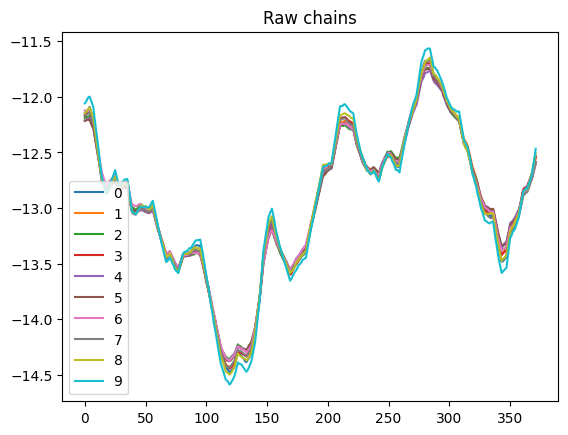

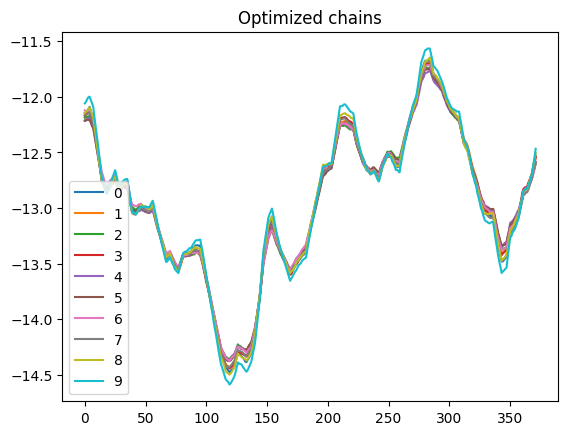

Best chain combination summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.234  0.077   0.102    0.370      0.005    0.004     190.0     435.0   
eps    1.501  0.184   1.142    1.833      0.003    0.002    2765.0    7774.0   
p_out  0.075  0.043   0.008    0.153      0.000    0.000   18875.0   13662.0   

       r_hat  
sig     1.06  
eps     1.00  
p_out   1.00  


In [33]:
selected_chains = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
remove_those = []
for i in remove_those:
    selected_chains.remove(i)


scou.visualize_latents(selected_chains)
scou.predict(selected_chains)

sub_data['muX'] = scou.muX
sub_data['ICL'] = scou.CIL
sub_data['ICU'] = scou.CIU
sub_data['pout'] = scou.pointwise_pout

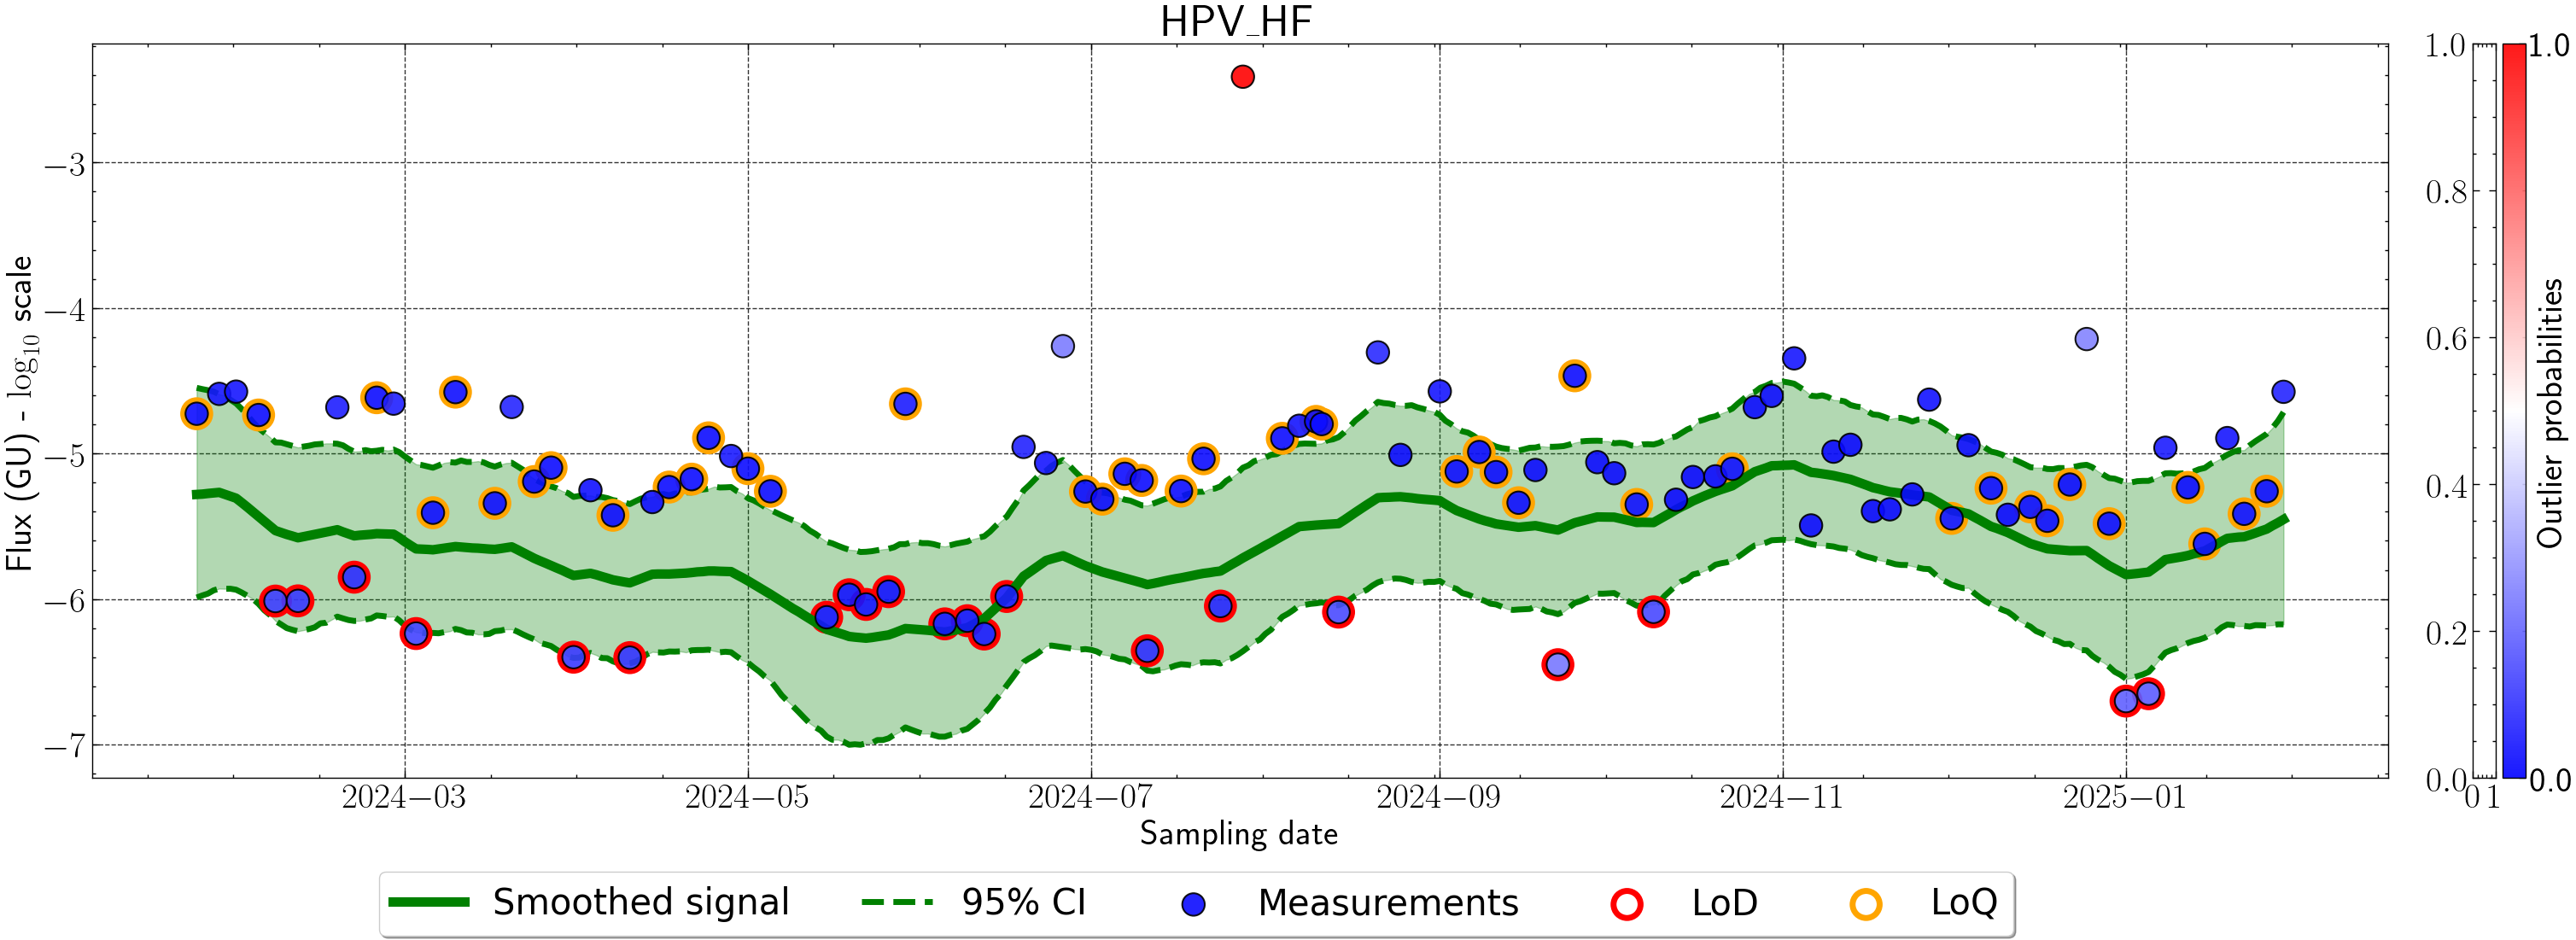

In [34]:
visualize_and_export(sub_data, obs_col, lod_col, loq_col, 'HPV_66_2025-10-30_ratio_crAssphages')

In [35]:
# then, mtDNA:

obs_col = 'obs_HPV_mtDNA'
lod_col = 'lod_HPV_mtDNA'
loq_col = 'loq_HPV_mtDNA'

observation_matrix = sub_data[obs_col].values
lod_matrix = sub_data[lod_col].values
loq_matrix = sub_data[loq_col].values

In [36]:
nb_chains = 10
tuning_iters = 4000
sampling_iters = 2000

scou = SCOU_RW_NUTS(observation_matrix, lod_matrix, loq_matrix, tuning_iters=tuning_iters, sampling_iters=sampling_iters,
                             export_name=None, 
                             p_out_frozen=False, nb_chains=nb_chains, export_chains=False,
                             RW_order=1)
scou.fit()

# Done
notify_mac("Jupyter", "Work done !")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 4 jobs)
NUTS: [sig, eps, p_out, latent]


Sampling 10 chains for 4_000 tune and 2_000 draw iterations (40_000 + 20_000 draws total) took 586 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Raw summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.238  0.077   0.114    0.387      0.007    0.005     133.0     361.0   
eps    1.474  0.246   1.009    1.931      0.002    0.001   13945.0   16513.0   
p_out  0.139  0.065   0.023    0.256      0.001    0.000   13110.0   16104.0   

       r_hat  
sig     1.08  
eps     1.00  
p_out   1.00  


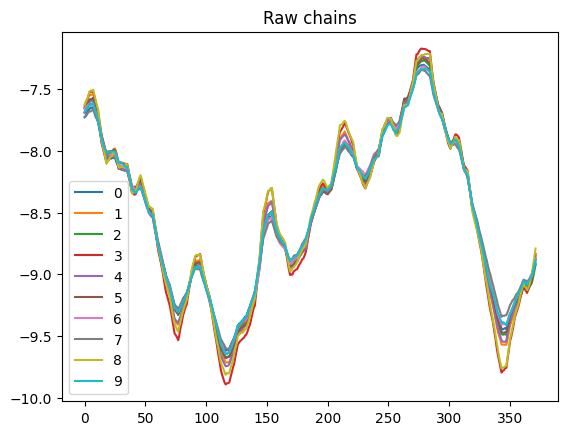

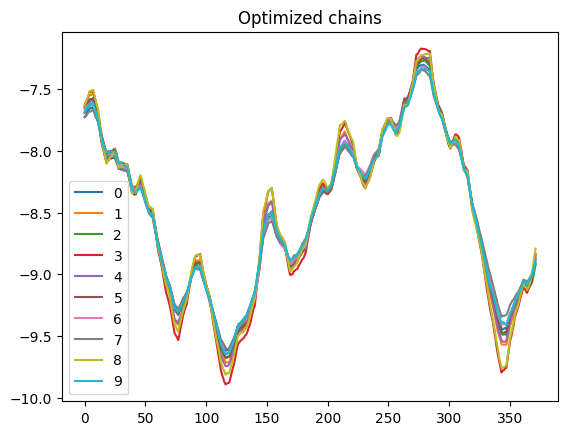

Best chain combination summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.238  0.077   0.114    0.387      0.007    0.005     133.0     361.0   
eps    1.474  0.246   1.009    1.931      0.002    0.001   13945.0   16513.0   
p_out  0.139  0.065   0.023    0.256      0.001    0.000   13110.0   16104.0   

       r_hat  
sig     1.08  
eps     1.00  
p_out   1.00  


In [37]:
selected_chains = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
remove_those = []
for i in remove_those:
    selected_chains.remove(i)


scou.visualize_latents(selected_chains)
scou.predict(selected_chains)

sub_data['muX'] = scou.muX
sub_data['ICL'] = scou.CIL
sub_data['ICU'] = scou.CIU
sub_data['pout'] = scou.pointwise_pout

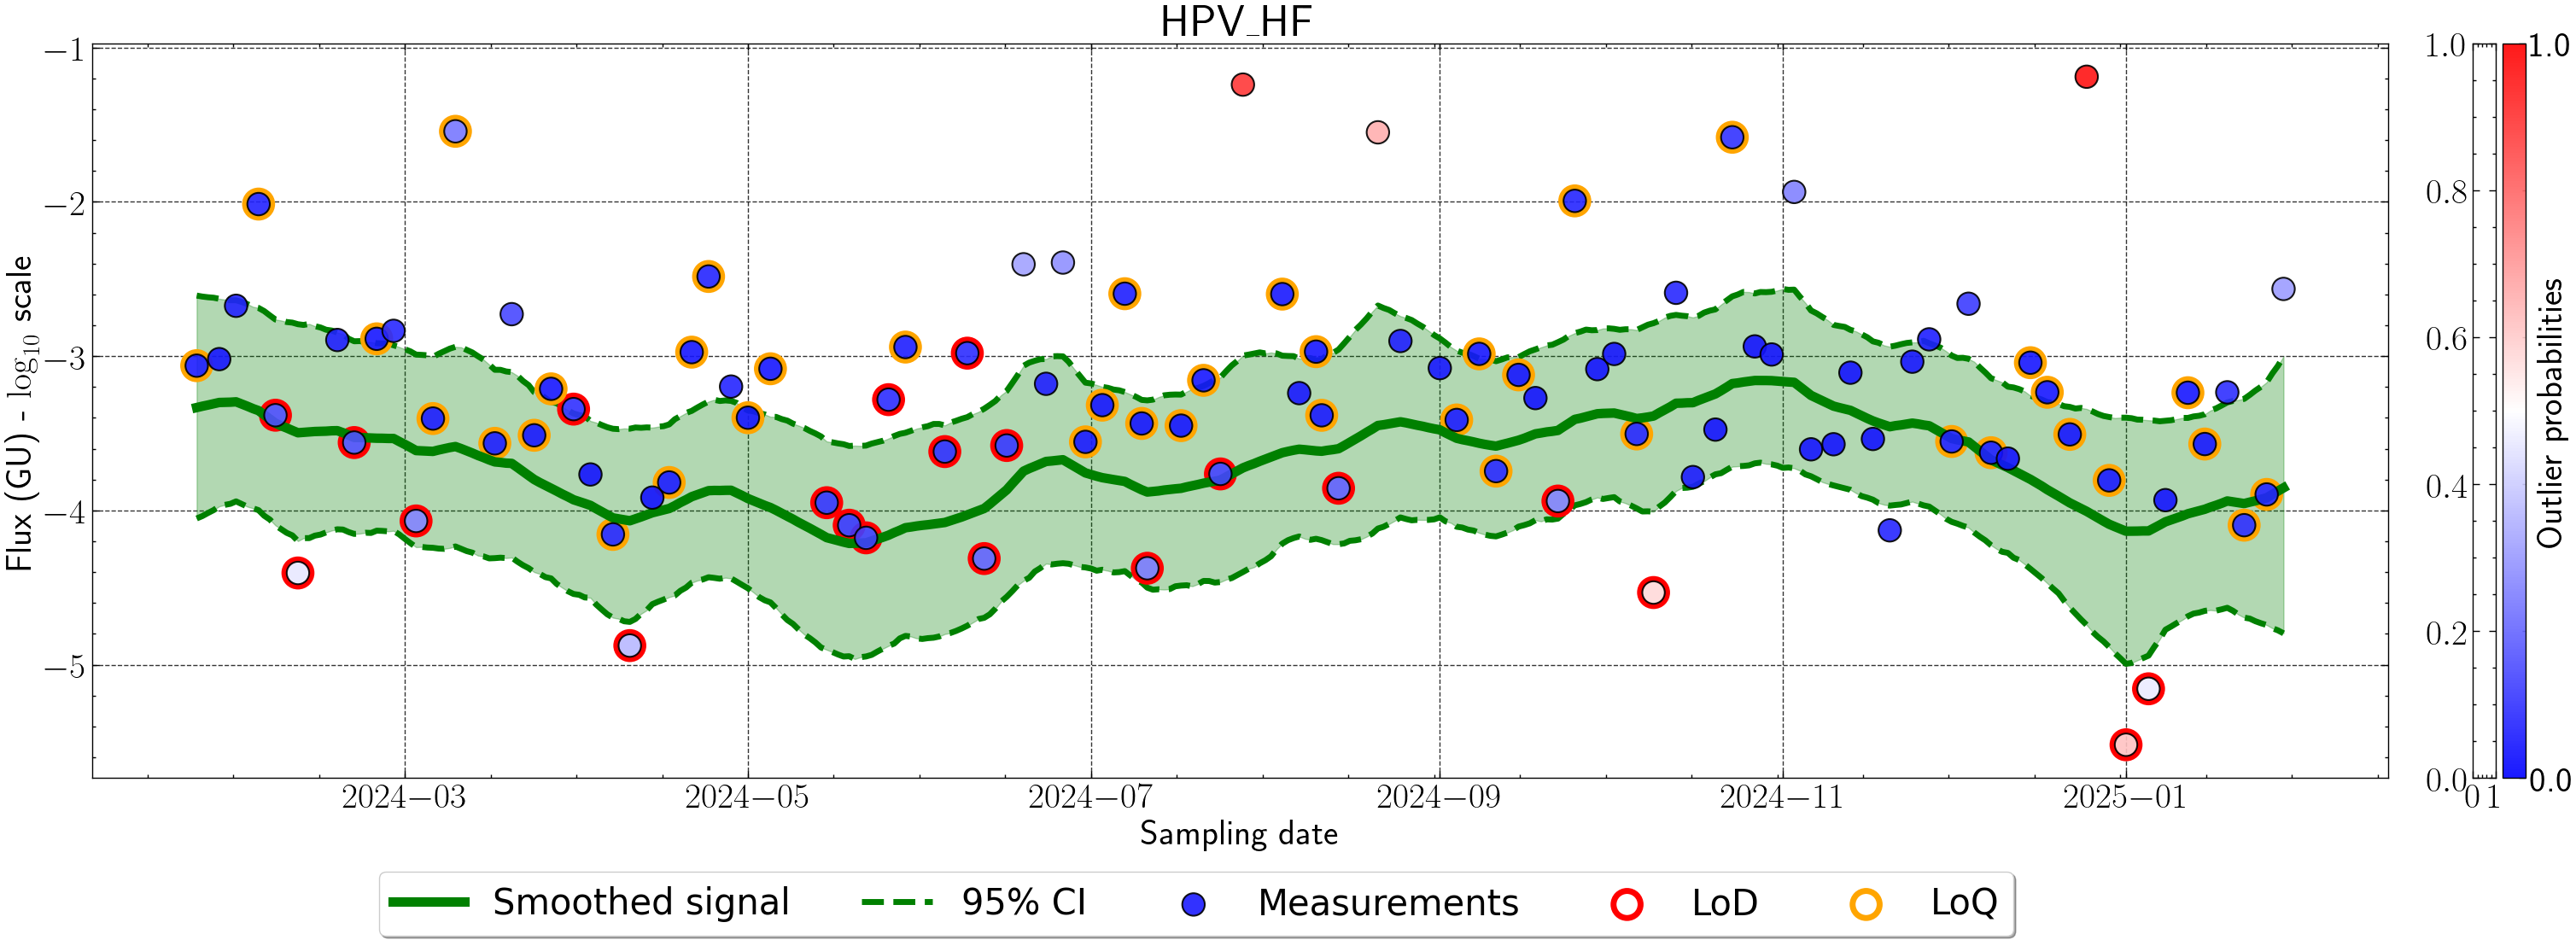

In [38]:
visualize_and_export(sub_data, obs_col, lod_col, loq_col, 'HPV_66_2025-10-30_ratio_mtDNA')

In [39]:
# then, flux:

obs_col = 'obs_flux'
lod_col = 'lod_flux'
loq_col = 'loq_flux'

observation_matrix = sub_data[obs_col].values
lod_matrix = sub_data[lod_col].values
loq_matrix = sub_data[loq_col].values

In [40]:
nb_chains = 10
tuning_iters = 4000
sampling_iters = 2000

scou = SCOU_RW_NUTS(observation_matrix, lod_matrix, loq_matrix, tuning_iters=tuning_iters, sampling_iters=sampling_iters,
                             export_name=None, 
                             p_out_frozen=False, nb_chains=nb_chains, export_chains=False,
                             RW_order=1)
scou.fit()

# Done
notify_mac("Jupyter", "Work done !")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 4 jobs)
NUTS: [sig, eps, p_out, latent]


Sampling 10 chains for 4_000 tune and 2_000 draw iterations (40_000 + 20_000 draws total) took 481 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Raw summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.265  0.084   0.131    0.428      0.006    0.004     195.0     483.0   
eps    1.494  0.223   1.125    1.923      0.005    0.003    2320.0    3674.0   
p_out  0.081  0.051   0.008    0.172      0.001    0.001    9182.0    4991.0   

       r_hat  
sig     1.03  
eps     1.00  
p_out   1.00  


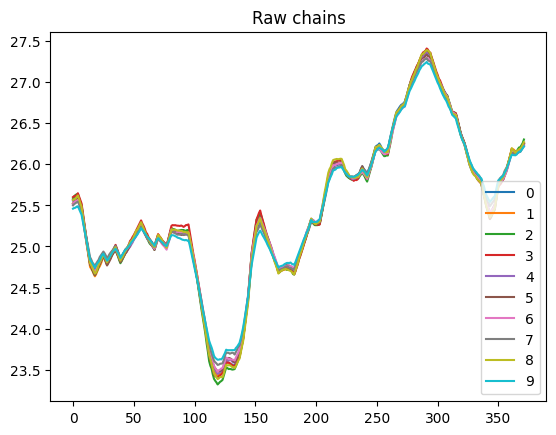

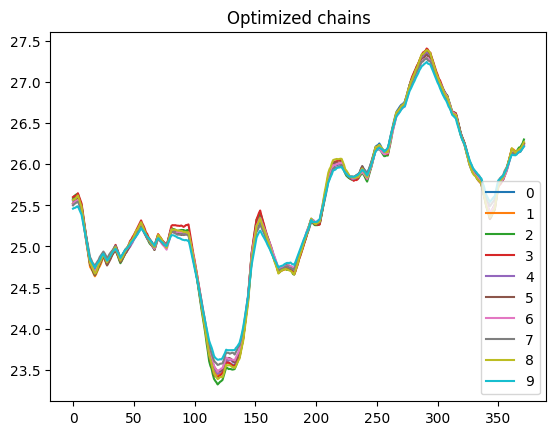

Best chain combination summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.265  0.084   0.131    0.428      0.006    0.004     195.0     483.0   
eps    1.494  0.223   1.125    1.923      0.005    0.003    2320.0    3674.0   
p_out  0.081  0.051   0.008    0.172      0.001    0.001    9182.0    4991.0   

       r_hat  
sig     1.03  
eps     1.00  
p_out   1.00  


In [41]:
selected_chains = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
remove_those = []
for i in remove_those:
    selected_chains.remove(i)


scou.visualize_latents(selected_chains)
scou.predict(selected_chains)

sub_data['muX'] = scou.muX
sub_data['ICL'] = scou.CIL
sub_data['ICU'] = scou.CIU
sub_data['pout'] = scou.pointwise_pout

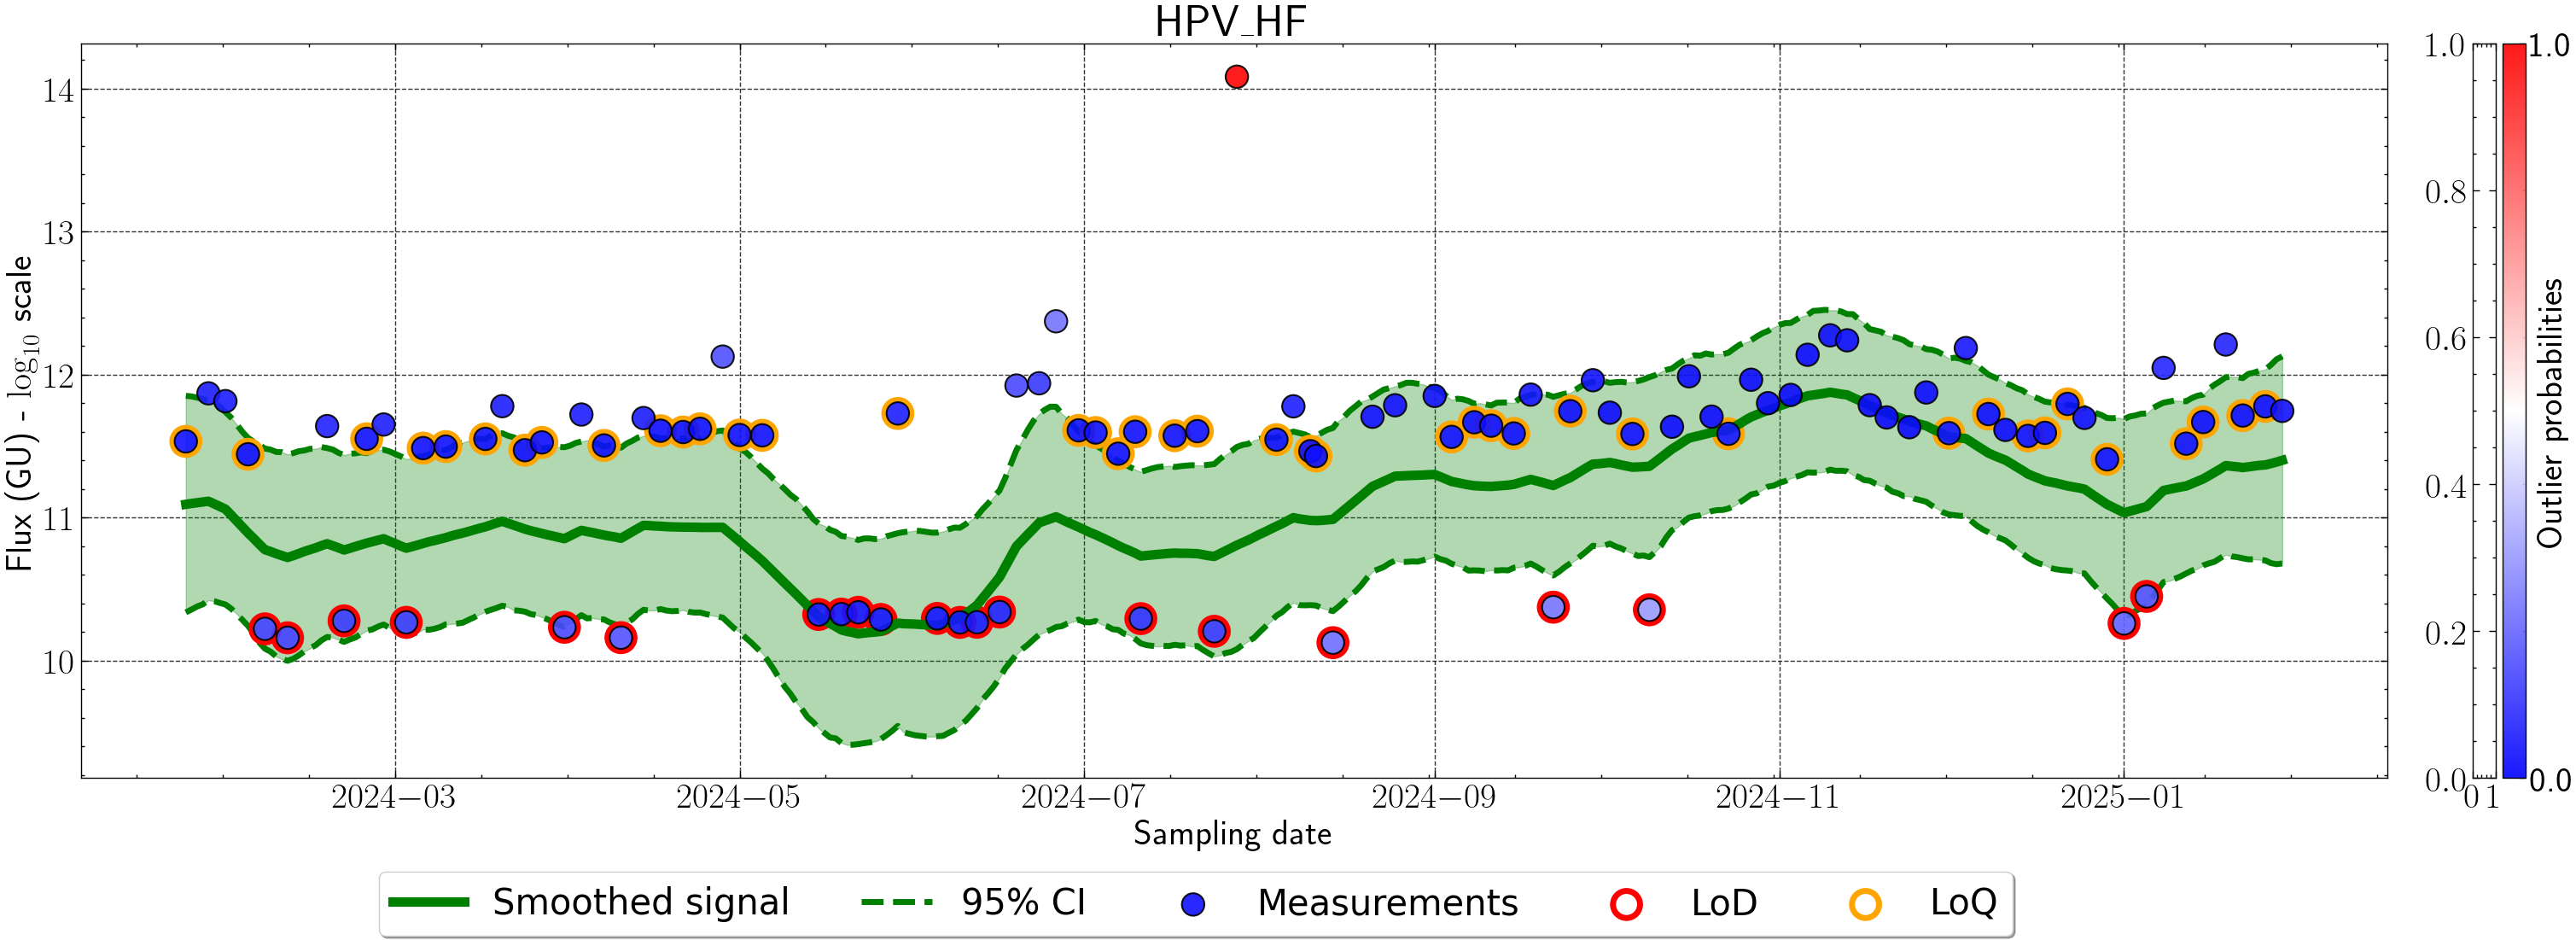

In [42]:
visualize_and_export(sub_data, obs_col, lod_col, loq_col, 'HPV_66_2025-10-30_ratio_flux')

In [43]:
# finally, conc:

obs_col = 'obs_HPV'
lod_col = 'lod_HPV'
loq_col = 'loq_HPV'

observation_matrix = sub_data[obs_col].values
lod_matrix = sub_data[lod_col].values
loq_matrix = sub_data[loq_col].values

In [44]:
nb_chains = 10
tuning_iters = 4000
sampling_iters = 2000

scou = SCOU_RW_NUTS(observation_matrix, lod_matrix, loq_matrix, tuning_iters=tuning_iters, sampling_iters=sampling_iters,
                             export_name=None, 
                             p_out_frozen=False, nb_chains=nb_chains, export_chains=False,
                             RW_order=1)
scou.fit()

# Done
notify_mac("Jupyter", "Work done !")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 4 jobs)
NUTS: [sig, eps, p_out, latent]


Sampling 10 chains for 4_000 tune and 2_000 draw iterations (40_000 + 20_000 draws total) took 497 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Raw summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.268  0.096   0.125    0.441      0.009    0.007     131.0     206.0   
eps    1.516  0.212   1.143    1.917      0.006    0.004    1426.0    1941.0   
p_out  0.076  0.047   0.007    0.161      0.000    0.000   13972.0    7971.0   

       r_hat  
sig     1.08  
eps     1.01  
p_out   1.00  


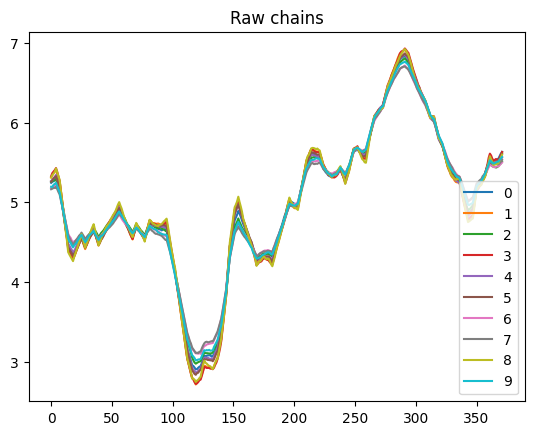

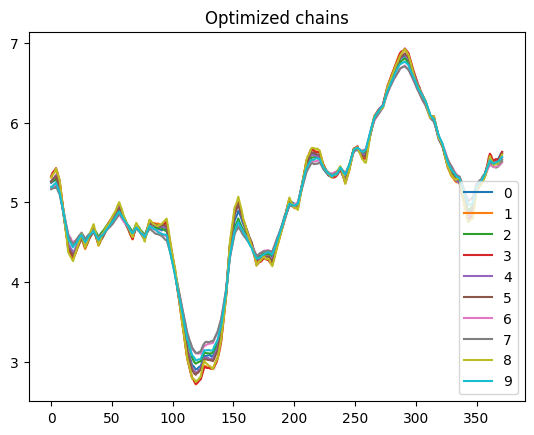

Best chain combination summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.268  0.096   0.125    0.441      0.009    0.007     131.0     206.0   
eps    1.516  0.212   1.143    1.917      0.006    0.004    1426.0    1941.0   
p_out  0.076  0.047   0.007    0.161      0.000    0.000   13972.0    7971.0   

       r_hat  
sig     1.08  
eps     1.01  
p_out   1.00  


In [45]:
selected_chains = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
remove_those = []
for i in remove_those:
    selected_chains.remove(i)


scou.visualize_latents(selected_chains)
scou.predict(selected_chains)

sub_data['muX'] = scou.muX
sub_data['ICL'] = scou.CIL
sub_data['ICU'] = scou.CIU
sub_data['pout'] = scou.pointwise_pout

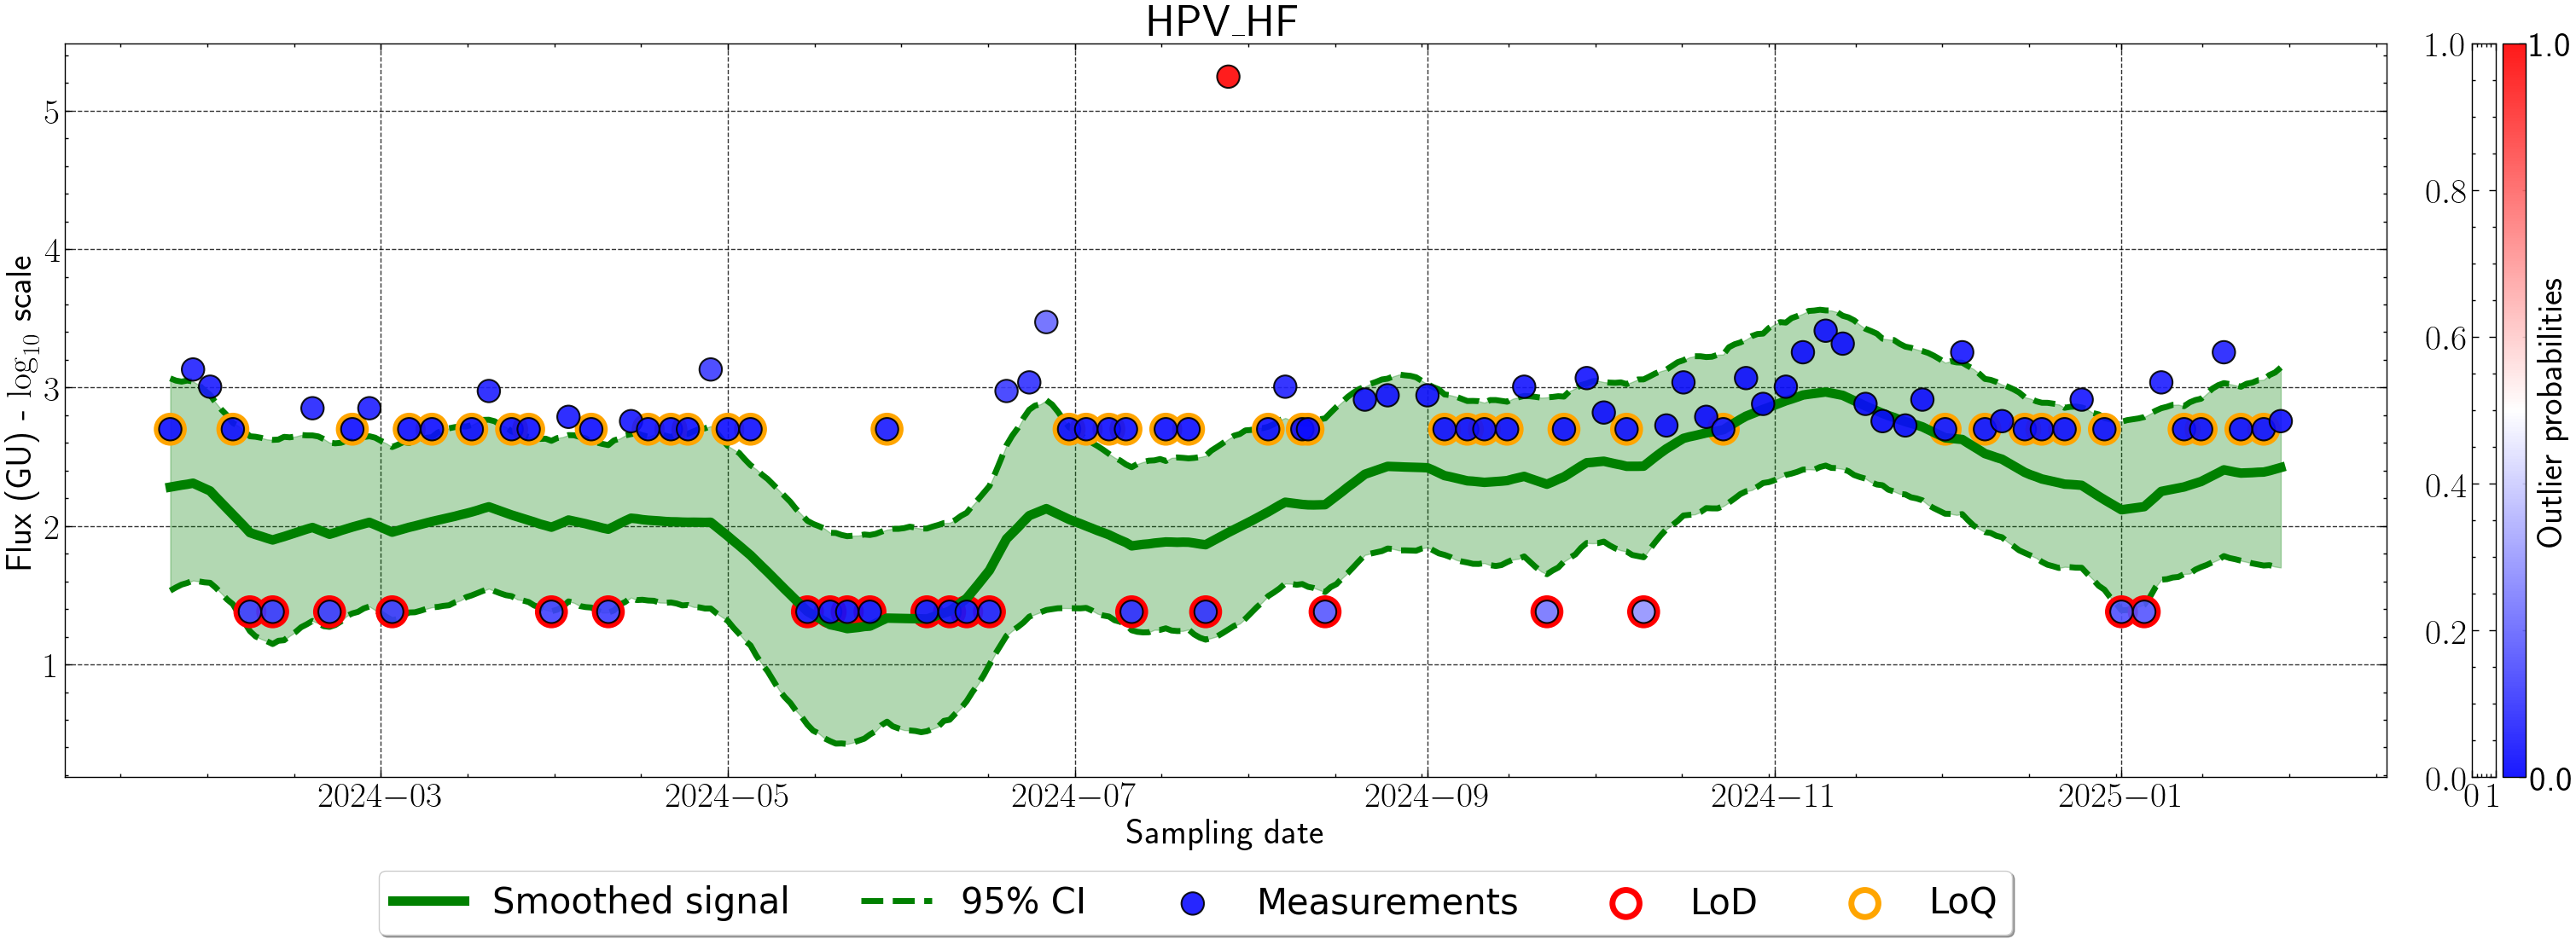

In [46]:
visualize_and_export(sub_data, obs_col, lod_col, loq_col, 'HPV_66_2025-10-30_ratio_conc')